In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import exponential, choice

from langevian_protein import run

In [2]:
residues = ['H', 'P', 'P', 'H', 'H']
coordinates = np.array([
    [0,0,1],
    [0,0,2],
    [0,0,3],
    [0,0,4],
    [0,0,5]
])
friction = 0.05
m = 1
kT = 2
dt = 0.003
k = 20
l = 1
iterations = 10000

In [3]:
potential_record, kinetic_record, energies, temperatures, total_forces, velocities, current_state = run(coordinates, m, residues, k, l, friction, kT, dt, iterations)

-0.1277384991091733 23.22472711444455 23.096988615335377
5.2754341725758245 12.47220579752912 17.747639970104945
0.9363022674465217 16.442871338650804 17.379173606097325
6.321800112430472 13.299402611353553 19.621202723784023
6.814686925387994 11.589527800896478 18.404214726284472
4.558344211885766 11.428500135690182 15.986844347575948
5.163963308925942 20.045028818365022 25.208992127290962
4.046249767187364 18.761798228802576 22.808047995989938
1.094933085131209 14.88804766650391 15.982980751635118
7.448832494670695 6.825610410520779 14.274442905191474


[]

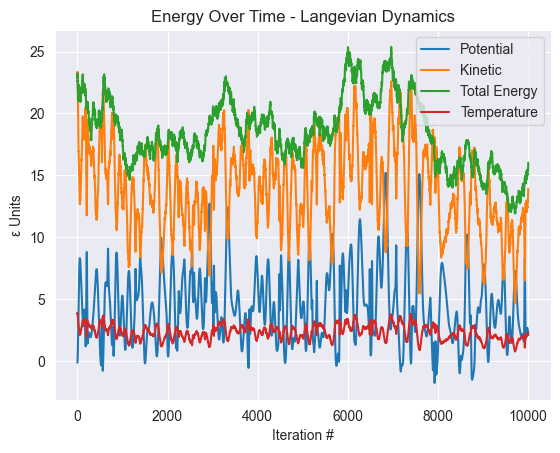

In [4]:
plt.figure()
x = [x for x in range(iterations+1)]
plt.plot(x, potential_record, label="Potential")
plt.plot(x, kinetic_record, label="Kinetic")
plt.plot(x, energies, label="Total Energy")
plt.plot(x, temperatures, label="Temperature")
plt.legend()
plt.xlabel("Iteration #")
plt.ylabel("ε Units")
plt.title("Energy Over Time - Langevian Dynamics")
plt.savefig("../../data/LangevianEnergy.png")
plt.plot()

In [5]:
print("Average Energy over last 1000 time steps: ")
print("Potential: ", np.mean(potential_record[-1000:]))
print("Kinetic: ", np.mean(kinetic_record[-1000:]))

Average Energy over last 1000 time steps: 
Potential:  3.771983421148716
Kinetic:  10.423938435554183


In [6]:
class Pm:
    conc_A = 1.5 # const concentration A; arbitrary concentration = um^-3
    conc_B = 4 # const concentration B; um^-3

    k1 = 1.0 #tu-1
    k2 = 1.0 #ac-2tu-1
    k3 = 1.0 #ac-1tu-1
    k4 = 1.0 #tu-1
    V = 2.0 #um^3, (eq/ ac^-1)
    x_init = 5.0 #um-3
    y_init = 1.0 #um-3
    M = 6

    def __init__(self, kdx = 0.01, kdy = 0.01):   #calculate Gillespie params
        self.k1g = self.k1  #tu-1
        self.k1Ag = self.k1g * self.conc_A * self.V #tu-1, k1Ag = c1 * nA
        self.k2g = 2 * self.k2 /self.V/self.V # tu-1
        self.k3g = self.k3 /self.V #tu-1
        self.k3Bg = self.k3g * self.conc_B * self.V #tu-1, k1Bg = c3 * nB
        self.k4g = self.k4 #tu-1
        self.xg_init = int(self.x_init * self.V)
        self.yg_init = int(self.y_init * self.V)
        self.kd1g = kdx #tu-1
        self.kd2g = kdy #tu-1

In [3]:
def propensities(y, c):
    prop = np.zeros([2, 6])

    prop[0][0] = pm.k1Ag # rxn1 L
    prop[0][1] = pm.k2g * y[0] * (y[0]-1)/2 * y[1] # rxn2 L
    prop[0][2] = pm.k3Bg * y[0] # rxn3 L
    prop[0][3] = pm.k4g * y[0] # rxn4 L
    prop[0][4] = pm.kd1g * y[0] # diff y[0] L->R
    prop[0][5] = pm.kd2g * y[1] # diff y[1] L->R

    prop[1][0] = pm.k1Ag # rxn1 R
    prop[1][1] = pm.k2g * y[2] * (y[2]-1)/2 * y[3] # rxn2 R
    prop[1][2] = pm.k3Bg * y[2] # rxn3 R
    prop[1][3] = pm.k4g * y[2] # rxn4 R
    prop[1][4] = pm.kd1g * y[2] # diff y[0] R->L
    prop[1][5] = pm.kd2g * y[3] # diff y[1] R->L

    return prop

In [13]:
def spatial_gillespie(max_time, stoich, pm):
    t = 0
    ts = [t]
    s = np.array([pm.xg_init, pm.yg_init, pm.xg_init, pm.yg_init])
    prop = np.zeros(10)
    M = pm.M

    index = np.array(range(0, 6))
    states = [np.copy(s)]

    while t < max_time:
        a = propensities(s, pm)

        a_0 = np.sum(a, axis=1)
        tau = - (1 / a_0) * np.log(np.random.rand(2))
        min_time = np.argmin(tau)
        mu = np.random.choice(index, p=a[min_time]/a_0[min_time]) + M * min_time

        s += stoich[mu]
        t += tau[min_time]

        states.append(np.copy(s))
        ts.append(t)

    ts = np.array(ts)
    states = np.array(states)

    return states, ts

In [16]:
max_time = 25.0
pm = Pm()

stoich_matrix = np.array([[1, 0, 0, 0], [1, -1, 0, 0], [-1, 1, 0, 0], [-1, 0, 0, 0], [-1, 0, 1, 0], [0, -1, 0 ,1],
                        [0, 0, 1, 0], [0, 0, 1, -1], [0, 0, -1, 1], [0, 0, -1, 0], [1, 0, -1, 0], [0, 1, 0, -1]])


states, times = spatial_gillespie(max_time, stoich_matrix, pm)

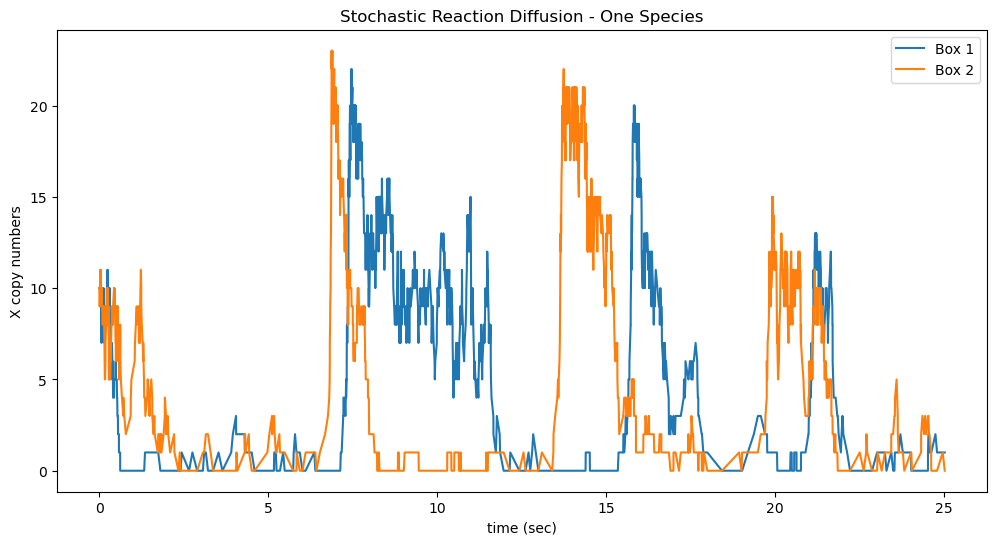

<Figure size 640x480 with 0 Axes>

In [18]:
states_t = np.transpose(states)
plt.figure(figsize=[12,6])

plt.plot(times, states_t[0], label="Box 1")
plt.plot(times, states_t[2], label="Box 2")


plt.xlabel("time (sec)")
plt.ylabel("X copy numbers")
plt.title("Stochastic Reaction Diffusion - One Species")
plt.legend()
plt.show()
plt.savefig("../../data/x_compartments.png")

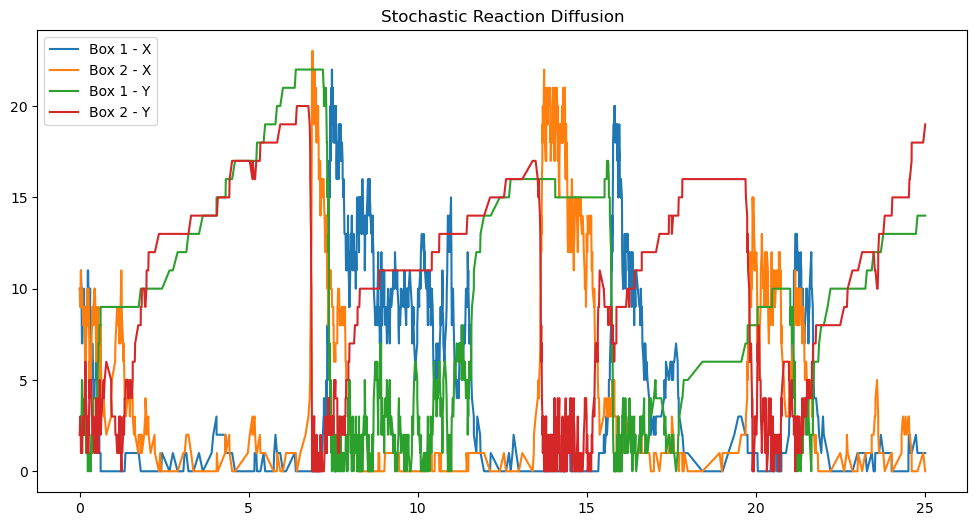

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=[12,6])

plt.plot(times, states_t[0], label="Box 1 - X")
plt.plot(times, states_t[2], label="Box 2 - X")

plt.plot(times, states_t[1], label="Box 1 - Y")
plt.plot(times, states_t[3], label="Box 2 - Y")

plt.title("Stochastic Reaction Diffusion")
plt.legend()
plt.show()
plt.savefig("../../data/Spatial_gillespie.png")
